<a href="https://colab.research.google.com/github/shahparth0007/Google_Collab_Files/blob/main/HRAnalytics_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HR Analytics Machine Learning Hackathon from 0 to 100**


---

In this Notebook we will solve HR Analytics Competition from Analytics Vidya!


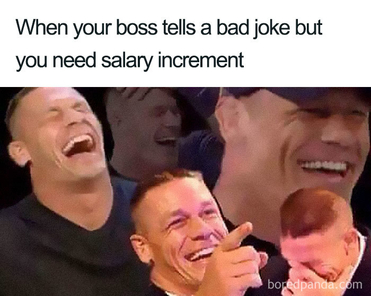


### ***✍🏻 Abstract***

---

Client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

They first identify a set of employees based on recommendations/ past performance
Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion

**The task is to predict whether a potential promotee at checkpoint in the test set will be promoted or not after the evaluation process.**


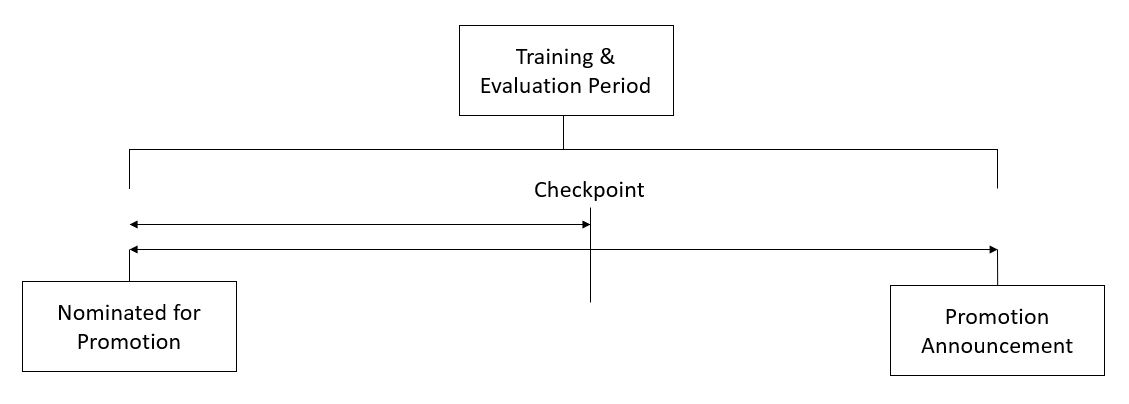


### ***✍🏻 Column Understanding (Logical way)***

---
Before diving into the data lets, lets understand the columns of the data and try to interpret them and make appropraite assumption!The data should support maximum of our assumptions! 



**1)** ***employee_id*** : Employee id of the employee (Should be unique across the data)

**2)** ***Department, Region, Education, Gender***: Demographic Variables of the employee as mentioned there are 9 departments across MNC. We can also assume some nulls present in education

**3)** ***no_of_trainings*** : no of other trainings completed in previous year on soft skills, technical skills etc. This can be an important variable and we can assume that more the no of training more knowldge the employee has for her/his department and more likely to perfrom well.

**GT no_of_trainings ∝ likely to get Promoted**

**4)** ***age*** : Age of an employee can also be a good predictor for y Variable! As older employees have very less positions for promotions which in turn make them less likely to get promoted which is inverse with younger employees!

### ***✍🏻 Importing Libraries***

---



In [ ]:
# Data Preprocessing, Machine Learning and Metrics Libraries 
!pip install shap
import pandas as pd
import numpy as np
import pylab as py
import missingno as msno
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Data Visualization
import seaborn as sns #Helps in plotting beautiful graphs and plots
import matplotlib 
import matplotlib.pyplot as plt #Helps in plotting beautiful graphs and plots
import shap

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier #Helps in Building Decision Tree Model
import statsmodels.api as sm
from xgboost import XGBClassifier
!pip install catboost
!pip install lightgbm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
import lightgbm as lgb
from hyperopt import hp, tpe
from hyperopt.fmin import fmin


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print('*** Libraries loaded ***')


pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


*** Libraries loaded ***


### ***✍🏻 Importing Data***

---
Importing Train and Validation (Leader Board data) from AV.
Here we will use 2 Datasets in total

**Train** : Train Data

**Validation** : The unseen data.


>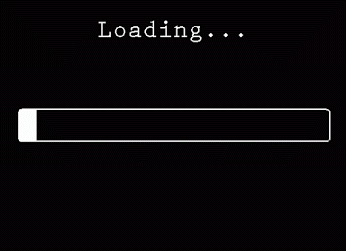




In [ ]:
raw_data_train = pd.read_csv("https://raw.githubusercontent.com/shahparth0007/Datasets/main/Train_HR_Analytics.csv")
raw_data_validation = pd.read_csv("https://raw.githubusercontent.com/shahparth0007/Datasets/main/Test_HR_Analytics.csv")

### ***✍🏻 Assignment Module 1: Data Checking*** (10 Points)

---

The data has been loaded now lets check the data.
Some of the check which we will do includes:

**1)** *Dublicates in the Data*

**2)** *Missing values in the Data*

**3)** *Garbage Values in the Data*

**4)** *Outliers in the Data*


In [ ]:
print("Shape of Train Data",raw_data_train.shape)
print("Shape of Validation Data",raw_data_validation.shape)

#Validation Data has one less column because that is the Response Column

Shape of Train Data (54808, 14)
Shape of Validation Data (23490, 13)


In [ ]:
raw_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [ ]:
raw_data_train.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

In [ ]:
# Change all Categorical variables to object type
for i in ['KPIs_met >80%','awards_won?']:
    raw_data_train[i] = np.where(raw_data_train[i] == 1, "Y", "N")
    raw_data_validation[i] = np.where(raw_data_validation[i] ==1, "Y" , "N")

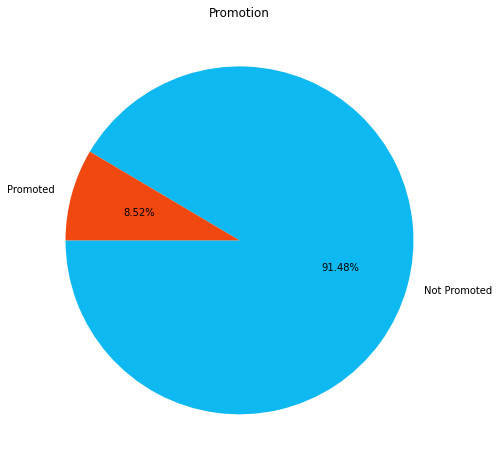

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))

ax.pie(raw_data_train.is_promoted.value_counts(), labels = ["Not Promoted", "Promoted"], 
       autopct = '%1.2f%%', startangle = 180, colors = ["#0EB8F1", "#F1480F"])

ax.set_title("Promotion")
plt.show()

#### ***📍Dublicates in the Data***

---
Sometimes the data might have dublicate records, which means same row more then once. Usally not a problem as there can be more then 1 employee with exactly same values but still we will remove any dublicate records as we have enough rows to build a model.


In [ ]:
# Removes Data Duplicates while Retaining the First one
def remove_duplicate(data):
    print("Shape of Data before Removing Dublicates:",data.shape)
    data.drop_duplicates(keep="first", inplace=True)
    print("Shape of Data after Removing Dublicates:",data.shape)

    return "Checked Duplicates"

# Removes Duplicates from train data
remove_duplicate(raw_data_train)
remove_duplicate(raw_data_validation)

Shape of Data before Removing Dublicates: (54808, 14)
Shape of Data after Removing Dublicates: (54808, 14)
Shape of Data before Removing Dublicates: (23490, 13)
Shape of Data after Removing Dublicates: (23490, 13)


'Checked Duplicates'

#### ***📍 Missing Values***

---
Missing Values are very commnon in datasets, an data without missing values is a myth. There are many ways to handle a missing value treatment.

**for Continuous Variables:**

Fill it with Mean,Median,0

**for Categorical Variables:**

Fill it with Forward Fill, Backward Fill, "Others"

First lets check what column has missing values and fill in accordingly


In [ ]:
##Lets find missing value columns
###Taken from Stackoverflow : https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe 

def missing_dataframe(data):
  missing_list = data.columns[data.isna().any()].tolist()
  missing_count = []
  for i in missing_list:
    missing_count.append(sum(pd.isnull(data[str(i)])))
  d = {'Missing_Column':missing_list,'Missing_Values':missing_count}
  Missing_DF = pd.DataFrame(d)
  Missing_DF["%_Missing"] = (Missing_DF['Missing_Values'] / data.shape[0]) * 100
  Missing_DF
  return Missing_DF

display("Train",missing_dataframe(raw_data_train))
display("Validation",missing_dataframe(raw_data_validation))


'Train'

,Missing_Column,Missing_Values,%_Missing
0,education,2409,4.395344
1,previous_year_rating,4124,7.524449


'Validation'

,Missing_Column,Missing_Values,%_Missing
0,education,1034,4.401873
1,previous_year_rating,1812,7.713921


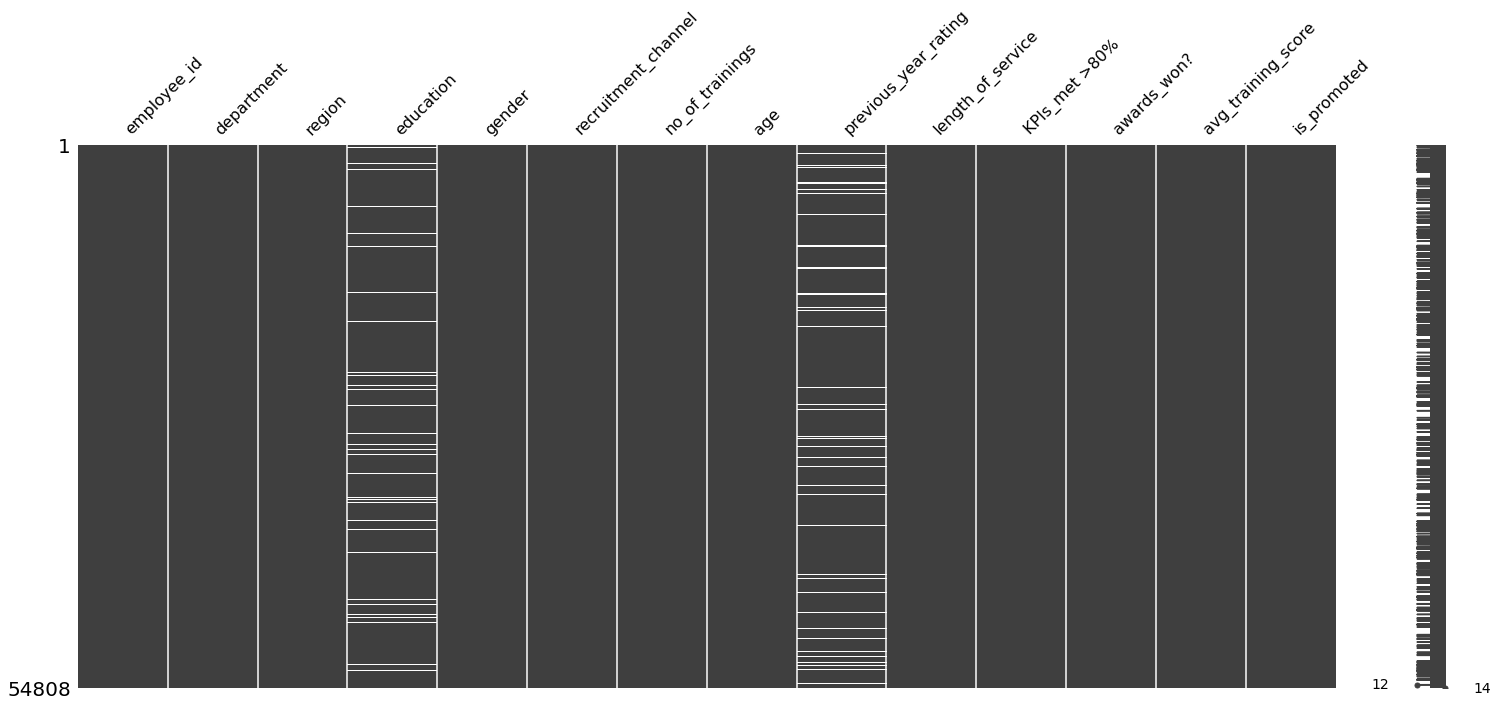

In [ ]:
#visulaizing missing data with a module
msno.matrix(raw_data_train) #https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

Missing value graphs shows at what point the missing values are there. This is much useful when the dara collected is sequential!

##### ***🔸 Missing Value for "previous_year_rating"***

---

Lets start by imputing missing value in this column.

In [ ]:
#lets first focus on "previous_year_rating"
print("Distinct year of Exp for people with Null previous year rating: ", raw_data_train[raw_data_train['previous_year_rating'].isna()]["length_of_service"].nunique())

Distinct year of Exp for people with Null previous year rating:  1


*Find 1:*  Upon looking closely we can see that people with 1 year exp do not have any previous year rating which is acceptable as they are fresher

*Conclusion of Find 1*: We can impute the missing values with 0 as they all are freshers and do not have rating which mean they should not be promoted

In [ ]:
print("Total Freshers with 1 year exp promoted:",raw_data_train[raw_data_train['previous_year_rating'].isna()]["is_promoted"].sum())

Total Freshers with 1 year exp promoted: 339


*Find 2:* If we go by conclusion of find 1 then we will imputing 0 for previous year rating and 339 people are promoted from them! Which is weird right! I mean which company will promote people with 0 rating duh...

*Conclusion of find 2:* So we will not be imputing 0 for NA. 

In [ ]:
def previous_year_rating_ratio(data):
  if 'is_promoted' in data.columns:
    previous_year_rating_ratio = data[['length_of_service','is_promoted']].groupby(['length_of_service']).sum()
    previous_year_rating_ratio['Total'] = data[['employee_id','length_of_service']].groupby(['length_of_service']).count()
    previous_year_rating_ratio['Avg_Rating'] =  data[['length_of_service','previous_year_rating']].groupby(['length_of_service']).mean()
    return previous_year_rating_ratio
  else:
    previous_year_rating_ratio = data[['employee_id','length_of_service']].groupby(['length_of_service']).count()
    previous_year_rating_ratio['Avg_Rating'] =  data[['length_of_service','previous_year_rating']].groupby(['length_of_service']).mean()
    return previous_year_rating_ratio

raw_data_rating_ratio = previous_year_rating_ratio(raw_data_train)
raw_data_validation_ratio = previous_year_rating_ratio(raw_data_validation)

In [ ]:
raw_data_rating_ratio.head()

,is_promoted,Total,Avg_Rating
length_of_service,,,
1,377,4547,3.262411
2,595,6684,3.316427
3,609,7033,3.328167
4,598,6836,3.320363
5,475,5832,3.336934


***Find 3:*** We can there are some employees with 1 year experience who have been promoted and also have some ratings. 

***Conclusion from find 3:*** We can taking the mean of that group of people and fill the missing values of this column. Bingo.

In [ ]:
raw_data_train["previous_year_rating"] = raw_data_train["previous_year_rating"].replace(np.nan,math.floor(raw_data_rating_ratio.iloc[0]['Avg_Rating']))
raw_data_validation["previous_year_rating"] = raw_data_validation["previous_year_rating"].replace(np.nan,math.floor(raw_data_validation_ratio.iloc[0]['Avg_Rating']))

##### ***🔸 Missing Value for "Education"***


In [ ]:
freq_df = raw_data_train.groupby(["department", "gender", "recruitment_channel"])["education"].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
pct_df

education                                     Bachelor's  ...  Master's & above
department        gender recruitment_channel              ...                  
Analytics         f      other                  0.908772  ...          0.091228
                         referred               1.000000  ...               NaN
                         sourcing               0.930693  ...          0.069307
                  m      other                  0.771326  ...          0.228674
                         referred               1.000000  ...               NaN
                         sourcing               0.781314  ...          0.218686
Finance           f      other                  0.768262  ...          0.188917
                         sourcing               0.773723  ...          0.171533
                  m      other                  0.751434  ...          0.209369
                         referred               1.000000  ...               NaN
                         sourcing               0.754499  ...          0.203085
HR                f      other                  0.621107  ...          0.333910
                         referred               0.603774  ...          0.226415
                         sourcing               0.619178  ...          0.315068
                  m      other                  0.663265  ...          0.292092
                         referred               0.700000  ...          0.200000
                         sourcing               0.634892  ...          0.312950
Legal             f      other                  0.811111  ...          0.111111
                         sourcing               0.762712  ...          0.203390
                  m      other                  0.784000  ...          0.152000
                         referred               1.000000  ...               NaN
                         sourcing               0.779570  ...          0.155914
Operations        f      other                  0.681836  ...          0.307385
                         referred               0.654321  ...          0.345679
                         sourcing               0.706088  ...          0.278942
                  m      other                  0.706384  ...          0.275179
                         referred               0.643312  ...          0.356688
                         sourcing               0.706676  ...          0.274352
Procurement       f      other                  0.614961  ...          0.366337
                         referred               0.586207  ...          0.413793
                         sourcing               0.619985  ...          0.361780
                  m      other                  0.631604  ...          0.351566
                         referred               0.666667  ...          0.333333
                         sourcing               0.618445  ...          0.361061
R&D               f      other                  0.589744  ...          0.410256
                         sourcing               0.666667  ...          0.333333
                  m      other                  0.545090  ...          0.454910
                         referred               0.578947  ...          0.421053
                         sourcing               0.565657  ...          0.434343
Sales & Marketing f      other                  0.702864  ...          0.297136
                         referred               1.000000  ...               NaN
                         sourcing               0.713057  ...          0.286943
                  m      other                  0.725770  ...          0.274230
                         referred               0.906780  ...          0.093220
                         sourcing               0.731000  ...          0.269000
Technology        f      other                  0.667105  ...          0.305921
                         referred               0.740385  ...          0.192308
                         sourcing               0.659272  ...          0.318545


In [ ]:
raw_data_train["education"] = raw_data_train["education"].replace(np.nan,"Bachelor's")
raw_data_validation["education"] = raw_data_validation["education"].replace(np.nan,"Bachelor's")

In [ ]:
raw_data_train.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

#### ***📍Garbage Value Checking***

---

Not always the values in the columns are meaningfull, there might be some values which does not fit the column description. We should check that and remove them. sus....

In [ ]:
for i in raw_data_train.columns.to_list():
  print("Column Name:",i,"Unique Values",raw_data_train[i].unique())

Column Name: employee_id Unique Values [65438 65141  7513 ... 13918 13614 51526]
Column Name: department Unique Values ['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal']
Column Name: region Unique Values ['region_7' 'region_22' 'region_19' 'region_23' 'region_26' 'region_2'
 'region_20' 'region_34' 'region_1' 'region_4' 'region_29' 'region_31'
 'region_15' 'region_14' 'region_11' 'region_5' 'region_28' 'region_17'
 'region_13' 'region_16' 'region_25' 'region_10' 'region_27' 'region_30'
 'region_12' 'region_21' 'region_8' 'region_32' 'region_6' 'region_33'
 'region_24' 'region_3' 'region_9' 'region_18']
Column Name: education Unique Values ["Master's & above" "Bachelor's" 'Below Secondary']
Column Name: gender Unique Values ['f' 'm']
Column Name: recruitment_channel Unique Values ['sourcing' 'other' 'referred']
Column Name: no_of_trainings Unique Values [ 1  2  3  4  7  5  6  8 10  9]
Column Name: age Unique Values [35 30 34 39 45 31 

#### ***📍 Outlier***

---
The data which is collected at companies will have outliers.

 Outliers are the data points which do not fall under normal range of that Column.

 We should do an Outlier treatment before building our model so that the model does not deviate from the actual data Points

We will be Using IQR (Inter quatile range) Outlier treatment for this data

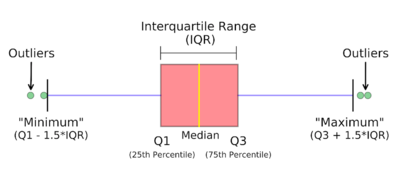



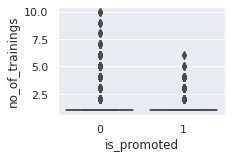

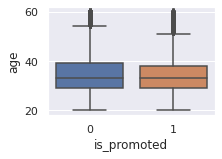

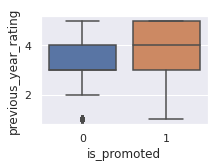

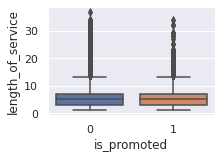

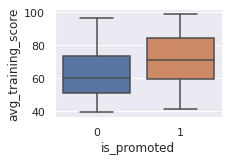

In [ ]:
numerics =['int16','int32','int64','float16','float32','float64']
train_numeric =raw_data_train.select_dtypes(include=numerics)
train_numeric = train_numeric.drop(['is_promoted','employee_id'], axis = 1)
sns.set(rc = {'figure.figsize':(3,2)})
for i, col in enumerate(train_numeric.columns.to_list()):
    plt.figure(i)
    sns.boxplot(raw_data_train['is_promoted'], y= col, data=raw_data_train)

One of the things which is very clear from the box plots is variable "previous_year_rating" has a clear difference in people who are getting promoted and people who are not! More the rating higher chances of getting promoted

In [ ]:
###outlier treatment
numerics =['int16','int32','int64','float16','float32','float64']
train_numeric =raw_data_train.select_dtypes(include=numerics)
vars_tobe_treated =list(train_numeric.columns)
vars_tobe_treated.remove('employee_id')
for cols in vars_tobe_treated:
    Q1 =raw_data_train[cols].quantile(0.25)
    Q3=raw_data_train[cols].quantile(0.75)
    if(Q1 == Q3):
        raw_data_train[cols] =raw_data_train[cols]
    else:
        print('Outlier Treatment happening on: '+ cols)
        IQR= Q3-Q1
        Upper_Limit = Q3+1.5*IQR
        Lower_Limit = Q1-1.5*IQR

        #Doing outlier on raw data
        raw_data_train[cols]=np.where(raw_data_train[cols] > Upper_Limit ,Upper_Limit,raw_data_train[cols])
        raw_data_train[cols]=np.where(raw_data_train[cols] < Lower_Limit ,Lower_Limit,raw_data_train[cols])

        #Doing outlier on Validation
        raw_data_validation[cols]=np.where(raw_data_validation[cols] > Upper_Limit ,Upper_Limit,raw_data_validation[cols])
        raw_data_validation[cols]=np.where(raw_data_validation[cols] < Lower_Limit ,Lower_Limit,raw_data_validation[cols])

print("Outlier_Treatment_Done");

Outlier Treatment happening on: age
Outlier Treatment happening on: previous_year_rating
Outlier Treatment happening on: length_of_service
Outlier Treatment happening on: avg_training_score
Outlier_Treatment_Done


### ***✍🏻 Assignment module 2: Feature Selection and Engineering***  (10 Points)

---



For feature selection lets do an correlation matrix first and look if we can delete any of the features which are highly correlated

In [ ]:
raw_data_train_cust_id = raw_data_train['employee_id']
raw_data_validation_cust_id = raw_data_validation['employee_id']
raw_data_train_response = raw_data_train['is_promoted']
raw_data_train_FE = raw_data_train.drop(['employee_id','is_promoted'],axis = 1)

#### ***📍Corellation Matrix***

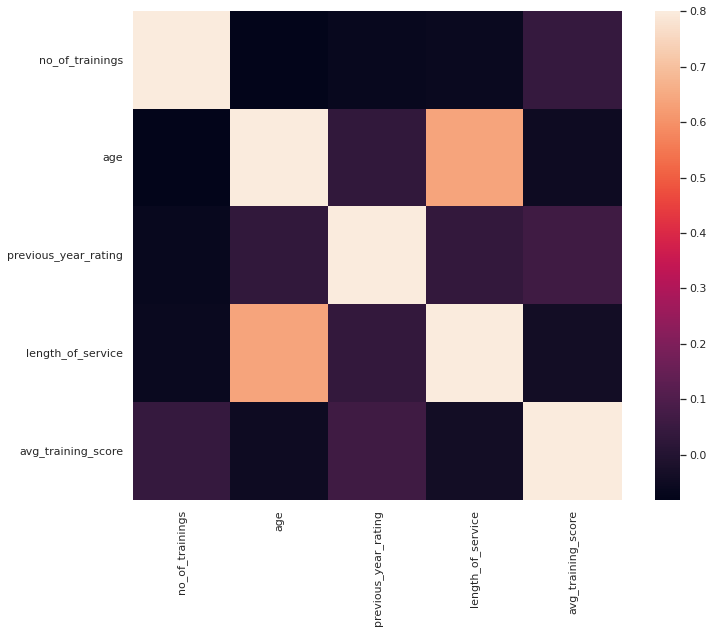

In [ ]:
#correlation matrix
corrmat = raw_data_train_FE.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
corrmat

,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score
no_of_trainings,1.000000,-0.082247,-0.062709,-0.059035,0.042517
age,-0.082247,1.000000,0.033864,0.640451,-0.049246
previous_year_rating,-0.062709,0.033864,1.000000,0.036243,0.065820
length_of_service,-0.059035,0.640451,0.036243,1.000000,-0.040358
avg_training_score,0.042517,-0.049246,0.065820,-0.040358,1.000000


**Insigths:** Looking at the correlation matrix first thing which is very clear that there is not much of negtaive corelation in the data.

Secondly we can see that the highest corelation is between length_of_service and age of 0.64 but that can be included in the model as it is not much high to ignore it completely.

#### ***📍CountPlots***

In [ ]:
#Code credits : https://www.kaggle.com/mustafacicek/hr-analytics-analyticsvidhya-8th-place-0-5329-f1

def count_percentage(df, col, hue):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
    order = sorted(df[col].unique())
    palette = ["#0EB8F1", "#F1480F"]
    
    sns.countplot(col, data = df, hue = hue, ax = ax1, order = order, palette = palette)
    ax1.set_title("Counts For Feature:\n" + col)

    df_temp = df.groupby(col)[hue].value_counts(normalize = True).\
    rename("percentage").\
    reset_index()
    
    fig = sns.barplot(x = col, y = "percentage", hue = hue, data = df_temp, ax = ax2, order = order, palette = palette)
    fig.set_ylim(0,1)
    
    fontsize = 14 if len(order) <= 10 else 8
    for p in fig.patches:
        
        txt = "{:.1f}".format(p.get_height() * 100) + "%"
        txt_x = p.get_x() 
        txt_y = p.get_height()
        fig.text(txt_x + 0.125, txt_y + 0.02,txt, fontsize = fontsize)

    ax2.set_title("Percentages For Feature: \n" + col)
    plt.setp(ax1.get_xticklabels(), rotation=70, horizontalalignment='right')
    plt.setp(ax2.get_xticklabels(), rotation=70, horizontalalignment='right')
    
    for ax in [ax1, ax2]:
        ax.set_facecolor("#C7D3D4FF")
        ax.grid(linewidth = 0.25)

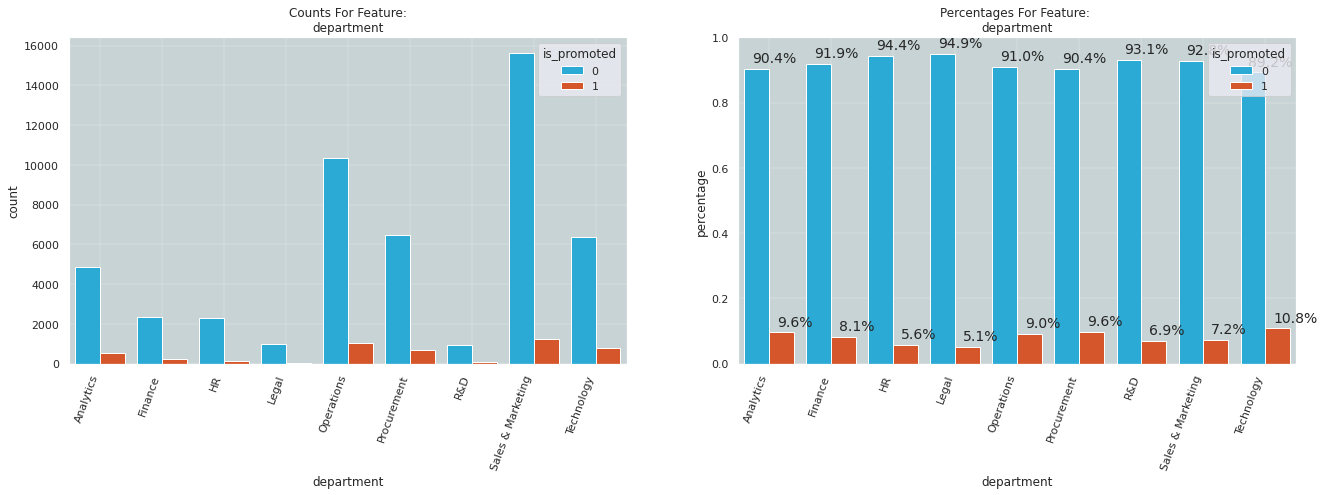

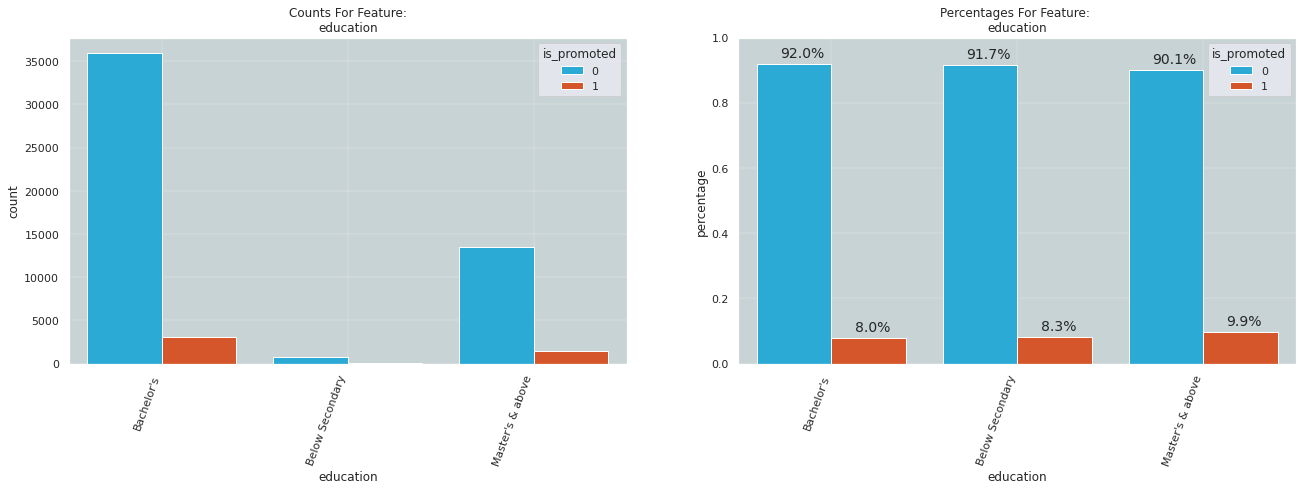

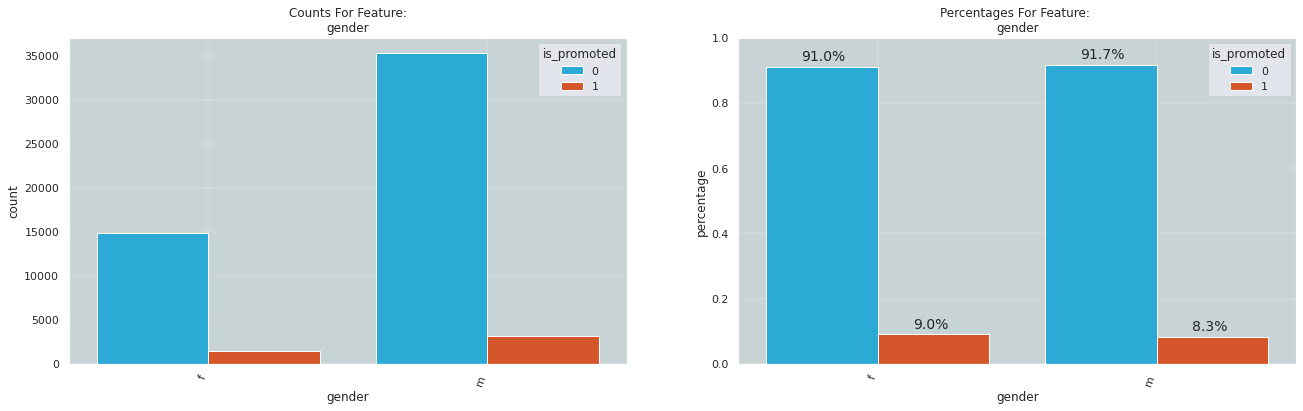

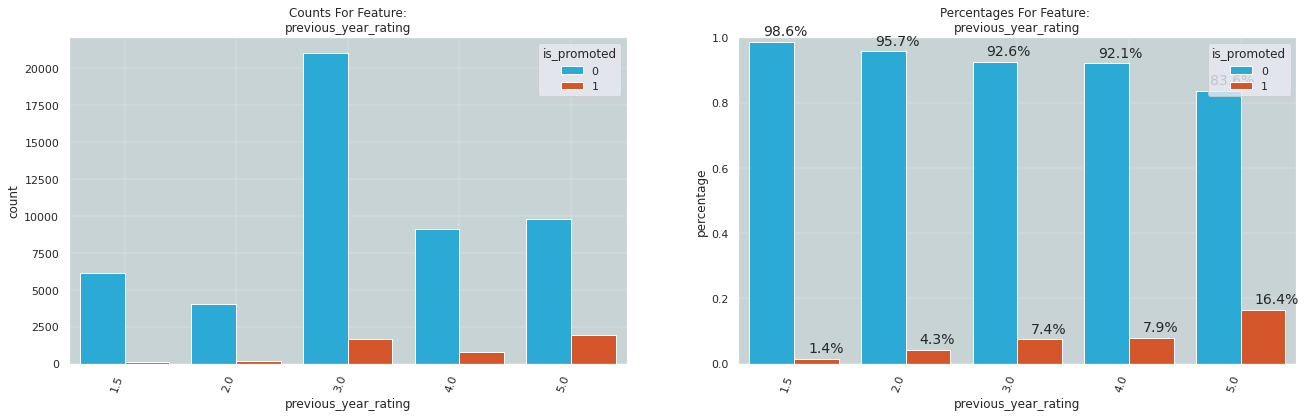

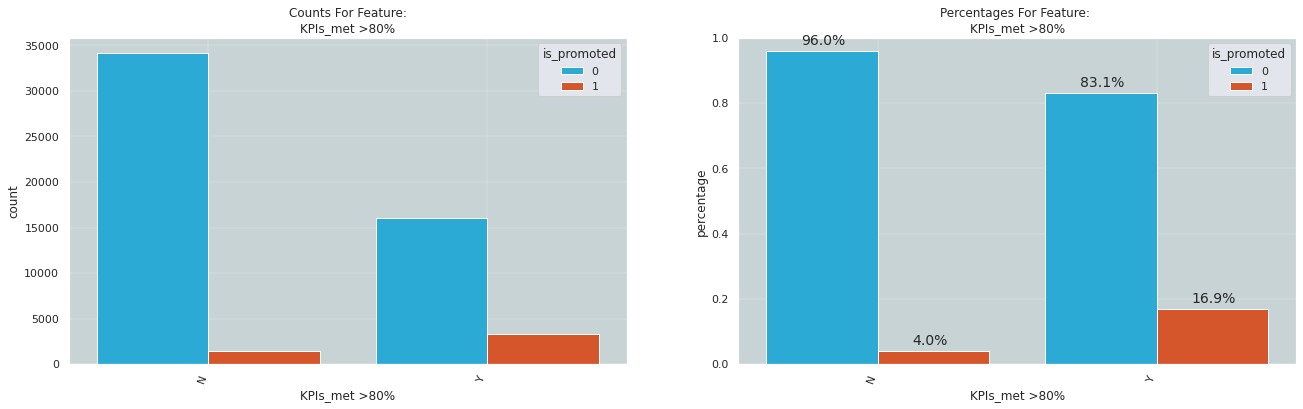

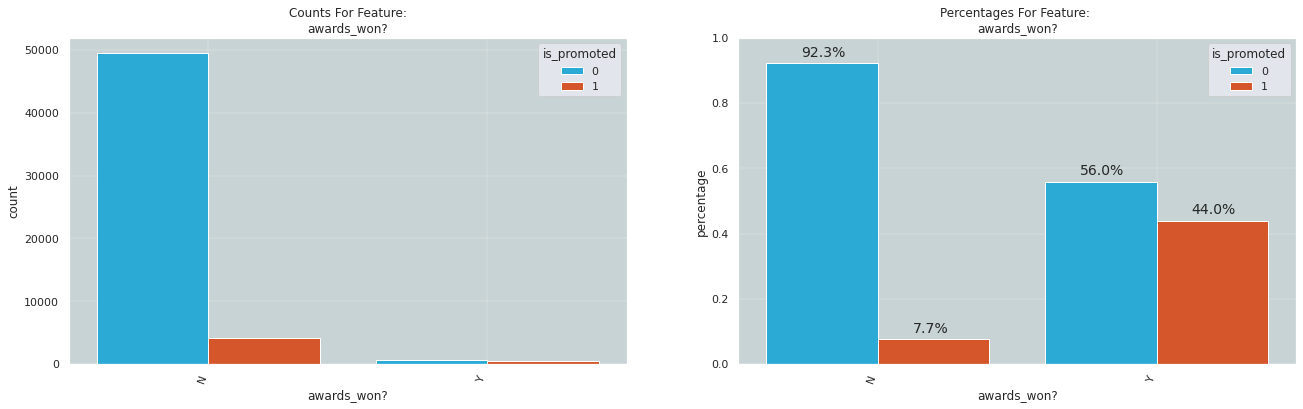

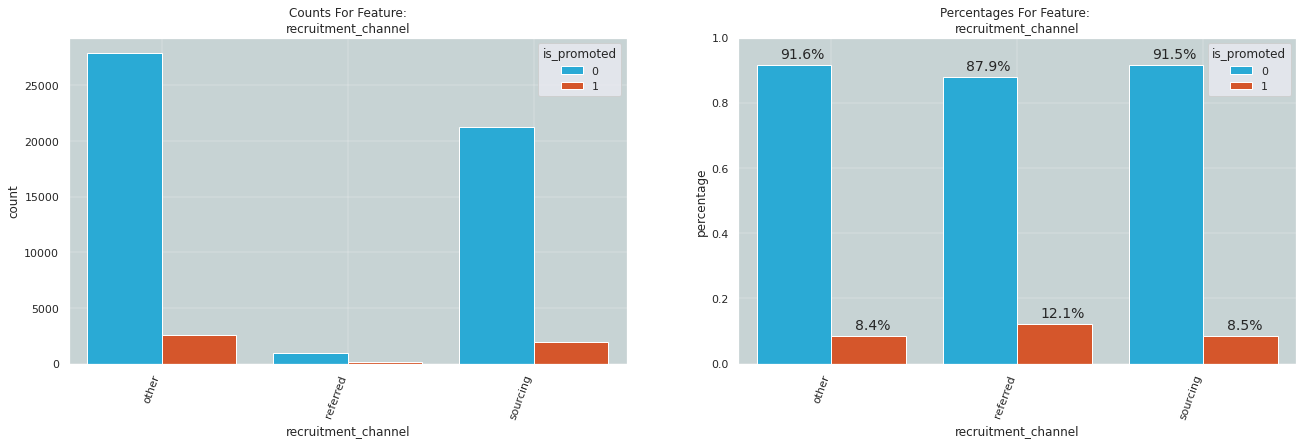

In [ ]:
CAT_LIST = ["department","education","gender","previous_year_rating","KPIs_met >80%","awards_won?",'recruitment_channel']
for i in CAT_LIST:
  count_percentage(raw_data_train, i, "is_promoted")

**Insights:**

Here we have plotted Bar Graphs or also called as count plots. They count the no of categories in the data and thne decide the height of the bar accordingly. Here we have also plotted % graphs to get acrually picture

1.   Wining awards definelty has an impact on getting promoted
2.   A good observation which we can see is that female have a higher % of promotions then men! Period. World is changing



#### ***📍Histograms***

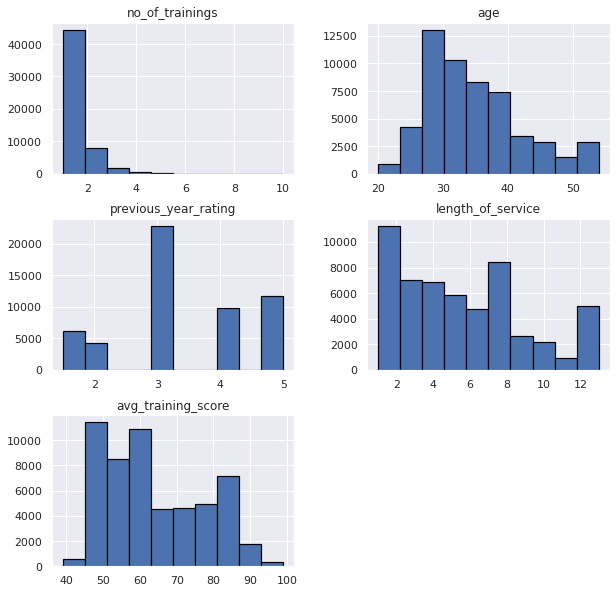

In [ ]:
raw_data_train_FE.hist(edgecolor='black', linewidth=1.2, figsize=(10, 10));

**Insights:** From Histograms we can see there are relatively more younger people and people with less experience in the company which are likely to be promoted

#### ***📍Feature Engineering***

##### ***🔸 Extra Feature Creation***

---
We can Bin the Continuos Variables such as Age to identify the pattern and to tell the model which age groups are similar in nature 


In [ ]:
def age_conditions_function(data):

  conditions = [
      (data['age'] >= 19) & (data['age'] < 25),
      (data['age'] >= 25) & (data['age'] < 30),
      (data['age'] >= 30) & (data['age'] < 40),
      (data['age'] >= 40),
      data['age'].isna()
      ]
  return conditions

values = ['19TO24', '25TO30', '30TO40','GT40','Not_Available']
raw_data_train['age_bands'] = np.select(age_conditions_function(raw_data_train), values)
raw_data_validation['age_bands'] = np.select(age_conditions_function(raw_data_validation), values)

display(raw_data_train[['age_bands','age','is_promoted']].groupby(['age_bands','is_promoted']).count())


age
age_bands is_promoted       
19TO24    0             1584
          1              131
25TO30    0            11643
          1             1095
30TO40    0            25474
          1             2556
GT40      0            11439
          1              886

In [ ]:
raw_data_train["education"] = raw_data_train["education"].map({"Below Secondary": 1, "Bachelor's": 2, "Master's & above":3})
raw_data_validation["education"] = raw_data_validation["education"].map({"Below Secondary": 1, "Bachelor's": 2, "Master's & above":3})

raw_data_train = raw_data_train.drop(['education'],axis = 1)
raw_data_validation = raw_data_validation.drop(['education'],axis = 1)

In [ ]:
raw_data_train["is_firstyear"] = raw_data_train["length_of_service"].apply(lambda x: 1 if x==1 else 0)
raw_data_train["starting_age"] = raw_data_train["age"] - raw_data_train["length_of_service"]
raw_data_train["total_success"] = raw_data_train["avg_training_score"]  + raw_data_train["previous_year_rating"]*20

raw_data_validation["is_firstyear"] = raw_data_validation["length_of_service"].apply(lambda x: 1 if x==1 else 0)
raw_data_validation["starting_age"] = raw_data_validation["age"] - raw_data_validation["length_of_service"]
raw_data_validation["total_success"] = raw_data_validation["avg_training_score"]  + raw_data_validation["previous_year_rating"]*20

##### ***🔸 Dummy Variable Creation***

In [ ]:
###creating dummies for model building#####
cols_to_keep_train = raw_data_train.columns.tolist()
cols_to_keep_validation = raw_data_validation.columns.tolist()
cols_to_keep_train.remove('is_promoted')
cols_to_keep_train.remove('employee_id')
cols_to_keep_validation.remove('employee_id')
def getFeatures(df , run_id, tuple_cols_toKeep):
    if(tuple_cols_toKeep is None):
        features = df
    else:
      features = pd.DataFrame(df, columns = tuple_cols_toKeep)
    features = pd.get_dummies(features,drop_first=True)
    return(features)
####calling the dummies function####
features_final_train = getFeatures(raw_data_train,'1020',cols_to_keep_train)
features_final_validation = getFeatures(raw_data_validation,'1020',cols_to_keep_validation)
print("The Shape of Dummy Variables are:",features_final_train.shape)
print("The Shape of Dummy Variables are:",features_final_validation.shape)

The Shape of Dummy Variables are: (54808, 57)
The Shape of Dummy Variables are: (23490, 57)


##### ***🔸 Scaling Values***

In [ ]:
def data_scaling( scaling_strategy , scaling_data , scaling_columns ):
    if    scaling_strategy =="RobustScaler" :
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])
    elif  scaling_strategy =="StandardScaler" :
        scaling_data[scaling_columns] = StandardScaler().fit_transform(scaling_data[scaling_columns])
    elif  scaling_strategy =="MinMaxScaler" :
        scaling_data[scaling_columns] = MinMaxScaler().fit_transform(scaling_data[scaling_columns])
    elif  scaling_strategy =="MaxAbsScaler" :
        scaling_data[scaling_columns] = MaxAbsScaler().fit_transform(scaling_data[scaling_columns])
    else :  # If any other scaling send by mistake still perform Robust Scalar
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])
    return scaling_data
# RobustScaler is better in handling Outliers :
scaling_strategy = ["RobustScaler", "StandardScaler","MinMaxScaler","MaxAbsScaler"]
X_train_scale = data_scaling( scaling_strategy[0] , features_final_train , features_final_train.columns )
X_Validation_scale = data_scaling( scaling_strategy[0] , features_final_validation , features_final_validation.columns )

In [ ]:
print("Final TRAIN Dataset has:",X_train_scale.shape[0],"rows and",X_train_scale.shape[1],"columns")
print("Total TRAIN Employees:",raw_data_train_cust_id.shape[0])
print("Total TRAIN Response:",raw_data_train_response.shape[0])

print("Final VALIDATION Dataset has:",X_Validation_scale.shape[0],"rows and",X_Validation_scale.shape[1],"columns")
print("Total VALIDATION Employees:",raw_data_validation_cust_id.shape[0])

Final TRAIN Dataset has: 54808 rows and 57 columns
Total TRAIN Employees: 54808
Total TRAIN Response: 54808
Final VALIDATION Dataset has: 23490 rows and 57 columns
Total VALIDATION Employees: 23490


In [ ]:
X_train_scale.to_csv('Train_Data.csv',index = False)
raw_data_train_response.to_csv('Train_Response.csv',index = False)

### ***✍🏻 Assignment Module 3: Multiple Optimized Models*** (10 Points)

#### ***📍Baseline Models***

In [ ]:
# Baseline Model Without Hyperparameters :
# Boosting Algorithms 
Classifiers = {'Logisticregression' : LogisticRegression(),
               'XGBoost' : XGBClassifier(),
               'CatBoost' : CatBoostClassifier(silent=True),
               'LightGBM' : LGBMClassifier(),
               'DecisionTree' : DecisionTreeClassifier()
 }

In [ ]:
voting_model = VotingClassifier(estimators=[
('Logistic_Best', list(Classifiers.values())[0]),
('XGBoost_Best', list(Classifiers.values())[1]),
('CatBoost_Best', list(Classifiers.values())[2]),
('LightGBM_Best', list(Classifiers.values())[3]),
('Decision_Tree_Best', list(Classifiers.values())[4])
],
voting='soft',weights=[5,5,5.9,5.3,0])
voting_model.fit(features_final_train,raw_data_train_response)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


VotingClassifier(estimators=[('Logistic_Best',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('XGBoost_Best',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsa...
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                  

In [ ]:
# calculate AUC for Train
#predictions_of_voting_prob = voting_model.predict_proba(X_train_scale)[::,1]
results = {}
predictions_of_voting_class = voting_model.predict(features_final_train)
#predictions_of_voting_class_validation = voting_model.predict(X_Validation_scale)

#print('Train AUC for Voting Classifier: %.3f' % roc_auc_score(raw_data_train_response, predictions_of_voting_prob))
f1_score1 = f1_score(raw_data_train_response, predictions_of_voting_class, average='macro')
print('Train F1 for Voting Classifier: %.3f' % f1_score1)
results['VotingClassifier'] = f1_score1

Train F1 for Voting Classifier: 0.742


In [ ]:
a = list(Classifiers.values())
for i in range(len(a)):
  a[i].fit(features_final_train,raw_data_train_response)
  predictions_of_voting_prob = a[i].predict_proba(features_final_train)[::,1]
  predictions_of_voting_class = a[i].predict(features_final_train)
  print(list(Classifiers.keys())[i],' Train AUC: %.3f'% roc_auc_score(raw_data_train_response, predictions_of_voting_prob))
  print(list(Classifiers.keys())[i],' Train F1 : %.3f' % f1_score(raw_data_train_response, predictions_of_voting_class, average='macro'))
  results[list(Classifiers.keys())[i]] = f1_score(raw_data_train_response, predictions_of_voting_class, average='macro')


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logisticregression  Train AUC: 0.876
Logisticregression  Train F1 : 0.672
XGBoost  Train AUC: 0.900
XGBoost  Train F1 : 0.686
CatBoost  Train AUC: 0.957
CatBoost  Train F1 : 0.773
LightGBM  Train AUC: 0.942
LightGBM  Train F1 : 0.748
DecisionTree  Train AUC: 1.000
DecisionTree  Train F1 : 0.999


In [ ]:
results

{'CatBoost': 0.7729829166277128,
 'DecisionTree': 0.9985328819702206,
 'LightGBM': 0.7476276057840302,
 'Logisticregression': 0.6724150258697351,
 'VotingClassifier': 0.7418805590546687,
 'XGBoost': 0.6859223779820799}

#### ***📍Hyperparameter Models***


---
After having basic models we will tune some parameters inside the models and try to test our validation set on that.


##### ***🔸 Grid Search***

---

In [ ]:
# f1_scorer = make_scorer(f1_score)
# skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# def objective(params):
#     params = {
#         'max_depth': int(params['max_depth']),
#         'num_leaves': int(params['num_leaves']),
#         'min_child_samples': int(params['min_child_samples']),
#         'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
#         'subsample': '{:.3f}'.format(params['subsample']),
#         'min_split_gain': '{:.3f}'.format(params['min_split_gain']),
#         'scale_pos_weight': '{:.3f}'.format(params['scale_pos_weight']),
#         'reg_alpha': '{:.3f}'.format(params['reg_alpha']),
#         'reg_lambda': '{:.3f}'.format(params['reg_lambda']),
#     }
    
#     clf = lgb.LGBMClassifier(
#         n_estimators = 500,
#         learning_rate = 0.1,
#         n_jobs = -1,
#         random_state = 42,
#         **params
#     )
    
#     score = cross_val_score(clf, features_final_train.values, raw_data_train_response.values, scoring = f1_scorer, cv = skf).mean()
#     print("F1-score {:.3f} params {}".format(score, params))
#     return -score

# space = {
#     "max_depth": hp.quniform('max_depth', 3, 10, 1),
#     'num_leaves': hp.quniform('num_leaves', 20, 100, 10),
#     'min_child_samples': hp.quniform('min_child_samples', 50, 150, 10),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),

#     'subsample': hp.uniform('subsample', 0.3, 1.0),
#     'min_split_gain': hp.uniform('min_split_gain', 0, 0.5),
#     'scale_pos_weight': hp.uniform('scale_pos_weight', 2, 4),
#     'reg_alpha': hp.uniform('reg_alpha', 0, 5),
#     'reg_lambda': hp.uniform('reg_lambda', 0, 1),

# }
# rstate = np.random.RandomState(42)
# best = fmin(fn = objective,
#             space = space,
#             algo = tpe.suggest,
#             max_evals = 150,
#             rstate = rstate)

In [ ]:
# clf.fit(X_train_scale,raw_data_train_response)

In [ ]:
# clf.best_score_

##### ***🔸 Voting Classifier Hyperparameter Model***

---

In [ ]:
Classifiers = {'XGBoost' : XGBClassifier(learning_rate =0.1,
                                           n_estimators=494,
                                           max_depth=5,
                                           subsample = 0.70,
                                           verbosity = 0,
                                           scale_pos_weight = 2.5,
                                           updater ="grow_histmaker",
                                           base_score  = 0.2),
               'CatBoost' : CatBoostClassifier(learning_rate=0.15,
                                               silent=True,
                                                 n_estimators=494,
                                                 subsample=0.085,
                                                 max_depth=5,
                                                 scale_pos_weight=2.5),
               'LightGBM' : LGBMClassifier(subsample_freq = 2,
                                             objective ="binary",
                                             importance_type = "gain",
                                             verbosity = -1,
                                             max_bin = 60,
                                             num_leaves = 300,
                                             boosting_type = 'dart',
                                             learning_rate=0.15,
                                             n_estimators=494,
                                             max_depth=5,
                                             scale_pos_weight=2.5)
 }

In [ ]:
voting_model = VotingClassifier(estimators=[
('XGBoost_Best', list(Classifiers.values())[0]),
('CatBoost_Best', list(Classifiers.values())[1]),
('LightGBM_Best', list(Classifiers.values())[2])
],
voting='soft',weights=[5,5.9,5.3])
voting_model.fit(features_final_train,raw_data_train_response)

predictions_of_voting_class = voting_model.predict(features_final_train)
#predictions_of_voting_class_validation = voting_model.predict(X_Validation_scale)

#print('Train AUC for Voting Classifier: %.3f' % roc_auc_score(raw_data_train_response, predictions_of_voting_prob))
f1_score1 = f1_score(raw_data_train_response, predictions_of_voting_class, average='macro')
print('Train F1 for Voting Classifier: %.3f' % f1_score1)
results['VotingClassifier_hyperparameter'] = f1_score1

Train F1 for Voting Classifier: 0.802


##### ***🔸 LightGBM Hyperparameter Model***

---

It is a gradient boosting framework that makes use of tree based learning algorithms that is considered to be a very powerful algorithm when it comes to computation. It is considered to be a fast processing algorithm.




In [ ]:
LGBM_model = LGBMClassifier(n_estimators=10000, learning_rate=0.005, n_jobs = -1, random_state = 42, 
                         colsample_bytree = 0.3994433425727357, max_depth = 5, min_child_samples = 100,
                         num_leaves = 70, scale_pos_weight = 2.743189307803528, 
                         subsample = 0.9730690656599836, min_split_gain = 0.4990782438045411, 
                         reg_alpha = 4.231800280468554, reg_lambda = 0.276033039672689)

In [ ]:
LGBM_model.fit(features_final_train,raw_data_train_response)
b = LGBM_model.predict(features_final_train) 
results['LightGBM_Hyperparameter'] = f1_score(raw_data_train_response, b, average='macro')    

In [ ]:
cv_varimp_df = pd.DataFrame([features_final_train.columns.to_list(), LGBM_model.feature_importances_]).T
cv_varimp_df.columns = ['feature_name', 'varimp']
cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)

In [ ]:
important_variable = cv_varimp_df[cv_varimp_df['varimp'] > 700]['feature_name'].unique()

In [ ]:
LGBM_model.fit(features_final_train[list(important_variable)],raw_data_train_response)
b = LGBM_model.predict(features_final_train[list(important_variable)]) 
results['LightGBM_Hyperparameter_selectecd_variables'] = f1_score(raw_data_train_response, b, average='macro')    


##### ***🔸 CATBoost Hyperparameter Model***

---

In [ ]:
CATBoost_model = CatBoostClassifier(learning_rate=0.15,silent=True,n_estimators=494,subsample=0.085, max_depth=5,scale_pos_weight=2.5)

In [ ]:
CATBoost_model.fit(features_final_train,raw_data_train_response)
b = CATBoost_model.predict(features_final_train) 
results['CATBoost_Hyperparameter'] = f1_score(raw_data_train_response, b, average='macro')    

In [ ]:
results

{'CATBoost_Hyperparameter': 0.7917906053526316,
 'CatBoost': 0.7729829166277128,
 'DecisionTree': 0.9985328819702206,
 'LightGBM': 0.7476276057840302,
 'LightGBM_Hyperparameter': 0.7579259381138562,
 'LightGBM_Hyperparameter_selectecd_variables': 0.7552546120409604,
 'Logisticregression': 0.6724150258697351,
 'VotingClassifier': 0.7418805590546687,
 'VotingClassifier_hyperparameter': 0.8021297756092907,
 'XGBoost': 0.6859223779820799}

In [ ]:
results_dataframe = pd.DataFrame(list(results.items()))
display(results_dataframe)

,0,1
0,VotingClassifier,0.741881
1,Logisticregression,0.672415
2,XGBoost,0.685922
3,CatBoost,0.772983
4,LightGBM,0.747628
5,DecisionTree,0.998533
6,VotingClassifier_hyperparameter,0.802130
7,LightGBM_Hyperparameter,0.757926
8,LightGBM_Hyperparameter_selectecd_variables,0.755255
9,CATBoost_Hyperparameter,0.791791


### ***✍🏻Assignment Module 4: Interpretebility*** (10 Points)

In [ ]:
explainer = shap.TreeExplainer(CATBoost_model)


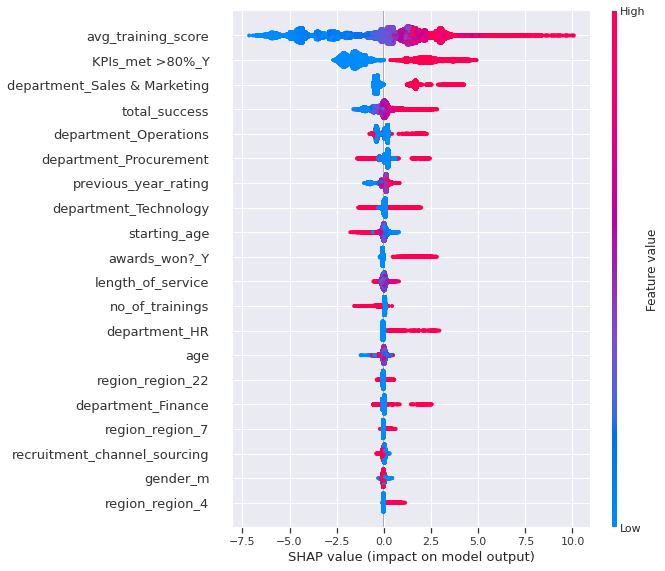

In [ ]:
shap_values = explainer.shap_values(X = X_train_scale)
shap.summary_plot(shap_values, X_train_scale)

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[13], X_train_scale.iloc[13,:],link= 'logit')

In [ ]:
raw_data_train_response.iloc[13]

0

The above row has has 2% percent probability of getting promoted and also we can see the Y variables is 0 for that particular row

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[60], X_train_scale.iloc[60,:],link= 'logit')

In [ ]:
raw_data_train_response.iloc[60]

1

The above row has has 58% percent probability of getting promoted and also we can see the Y variables is 1 for that particular row

In [ ]:
import math
a = 1+math.exp(0.34)
math.exp(0.34)/a

0.5841905229354074

***SHAP Values Interpretibilty:***

---


X axis indicates wether the input to the model has a postive or negative effect on the model. By Positive effect we mean wether that person is more likely to get promotion by negative vice versa.

Y axis inditicate the value of that variable range color goes from blue to red where blue indicate low value of that variable and red indicates high value.



1.   avg_training_score: The defination of this variable indicates that this variables holds information about the score which the employee got in last year's training. Logically in real world more the training score better the knowldge that employee has for its domain and more likely he would perform well overall. This hypothesis is also reflected in our shap graphs. We can see red values are on the positive side of the graphs that means higher the value of avg_training_score more likely the person is going to be promoted.
2.   kpi_met_80_y : By Defination a person meeting there KPI last year will have 1 else 0. SHAP value tells us that if this column has 1 then that performs positive to the model. Well true in real life as well.




### ***✍🏻Assignment Module 5: Competition Score*** (10 Points)

In [ ]:
# To make validation csv
predictions_of_voting_class_validation = CATBoost_model.predict(features_final_validation)
probabilties_of_voting_class_validation = CATBoost_model.predict_proba(features_final_validation)
# Round off the Probability Results :
Result_Promoted = pd.DataFrame({'employee_id': raw_data_validation_cust_id, 'is_promoted' : predictions_of_voting_class_validation})  
Result_Promoted.to_csv("Submission_file.csv", index= False)

### ***✍🏻Assignment Module 6: Summary*** (25 Points)

---

List of things in public jupyter notebooks:


1.   The missing value for "previous_year_rating" has been put 0 in all notebooks
2.   Not much Extra Variables Added
3.   No voting classifier used
4.   Did not build a model on top variables only.

Things done differently in this notebook then public kernals

1. For missing Value of "previous_year_rating" we have updated it with the mean value of people who have been promoted with 1 year experience previous_year_rating. As there are people with 1 year experience who got promted we are not concluding that people with missing value are people who are not eligible for promotion.

2. We have added 5 extra derived variables which where not present in given dataset or public kernals.
is_firstyear,starting_age,total_success,age_bands
and total_success is also coming as the important variable among those.

3. We have used voting classifier which ensembles multiple alogithms and gives final predictions

4. Finally we have build a model on only top important variables for an better accuracy.


 


### ***✍🏻Conclusion***

---
To Conclude the collab notebook. We have done following steps:


1.   Cleaned Dataset
2.   Performed Missing Value Treatment
3.   Performed Outlier Treatment
4.   Did One hot encoding
5.   Build Baseline Model
6.   Hyperparameter Tuning
7.   SHAPLey Values





### ***✍🏻Citations***

---
Shapley Value : https://colab.research.google.com/drive/156GaHXovHeXCmvUhwvL4Ootpn5Tf8dQv?usp=sharing#scrollTo=aFSXF-f6Xq97

https://drive.google.com/file/d/1p9yZEEDbWGmWZP6yNKupmLzxTaiz0R39/view

Histogram : https://www.kaggle.com/mustafacicek/hr-analytics-analyticsvidhya-8th-place-0-5329-f1

Missing Value Graphs(MINISO) : https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

Vote Classifier: https://www.analyticsvidhya.com/blog/2020/10/ultimate-beginners-guide-top-10-machine-learning-hackathons/

GridSearch : https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt



## ***✍🏻License***

---


Begin license text.
Copyright 2021 Parth Bipin Shah NUID: 001006181

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.